<a href="https://colab.research.google.com/github/LiuP1994/click_through_rate/blob/master/click_through_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import files
# uploaded=files.upload()

In [0]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from gensim.models import FastText as fasttext
from sklearn.model_selection import StratifiedKFold
import math
color = sns.color_palette()
sns.set_style('darkgrid')

In [0]:
#导入数据
path='train_data.csv'
train_data = pd.read_csv(path,lineterminator='\n',index_col=False,names=['query_id','query','title_id','title','label'])

In [0]:
#清洗过长的query
# length=[]
# for n in range(train_data.shape[0]):
#   query_length=np.array(train_data['query'][n].split()).shape[0]
#   if query_length>50:
#     length.append(False)
#   else:
#     length.append(True)
# train_data=train_data[length].reset_index(drop=True)

In [0]:
#首先，将整个数据集7:2:1分为train valid test
x_train_val, x_test, y_train_val, y_test = train_test_split(train_data[['query','title','label']],
                                                     train_data['label'],
                                                     test_size=0.2,
                                                     random_state=33)

x_train, x_val, y_train, y_val = train_test_split(x_train_val,
                                                     y_train_val,
                                                     test_size=0.3,
                                                     random_state=33)


#重置index,使其从0开始
x_train_reset=x_train.reset_index(drop=True)
x_test_reset=x_test.reset_index(drop=True)
y_train_reset=y_train.reset_index(drop=True)
y_test_reset=y_test.reset_index(drop=True)
x_val_reset=x_val.reset_index(drop=True)
y_val_reset=y_val.reset_index(drop=True)

In [0]:
#计算query和title长度
def query_title_length(origin_data):
  query_length=np.zeros(origin_data.shape[0])
  title_length=np.zeros(origin_data.shape[0])
  for n in range(origin_data.shape[0]):
    title_length[n]=np.array(origin_data['title'][n].split()).shape[0]
    query_length[n]=np.array(origin_data['query'][n].split()).shape[0]
  return query_length,title_length

#长度差
def length_dif(query_length,title_length):
  return title_length-query_length

#长度比
def length_rate(query_length,title_length):
  return title_length/query_length

In [0]:
#统计相同词语出现的数目与query,title长度比值
def same_word(train_data,query_length,title_length):
  same_word=[]
  for i in range(train_data.shape[0]):
    k=0
    for l in train_data['query'][i]:
      if l in train_data['title'][i]:
        k+=1
    same_word.append(k)
  return same_word/query_length,same_word/title_length

In [0]:
#每个query中title条数
def title_number_per_query(train_data):
  count=train_data['title'].groupby(train_data['query']).count()
  title_number_per_query=pd.merge(train_data['query'],count,left_on='query',right_index=True,how='left')['title'].rename('title_number_per_query',inplace=True)
  return title_number_per_query

In [0]:
#计算编辑距离
def normal_leven(str1, str2):
      len_str1 = len(str1) + 1
      len_str2 = len(str2) + 1
      #create matrix
      matrix = [0 for n in range(len_str1 * len_str2)]
      #init x axis
      for i in range(len_str1):
          matrix[i] = i
      #init y axis
      for j in range(0, len(matrix), len_str1):
          if j % len_str1 == 0:
              matrix[j] = j // len_str1          
      for i in range(1, len_str1):
          for j in range(1, len_str2):
              if str1[i-1] == str2[j-1]:
                  cost = 0
              else:
                  cost = 1
              matrix[j*len_str1+i] = min(matrix[(j-1)*len_str1+i]+1,
                                          matrix[j*len_str1+(i-1)]+1,
                                          matrix[(j-1)*len_str1+(i-1)] + cost)          
      return matrix[-1]
def edit_distance(train_data):
  edit_distance=[]
  for i in range(train_data.shape[0]):
    edit_distance.append(normal_leven(train_data['query'][i],train_data['title'][i]))
  return edit_distance

In [0]:
#拼接query和title
for n in range(train_data.shape[0]):
    train_data.at[n,'query']=train_data['query'][n].split()
    train_data.at[n,'title']=train_data['title'][n].split()
word2vcorpus=pd.concat([train_data['query'],train_data['title']])

In [0]:
#对query和title语料库做word2vec
model=Word2Vec(word2vcorpus,min_count=1, size=100, window=5, workers=4)

In [0]:
def Jaccrad(model, reference):#terms_reference为源句子，terms_model为候选句子
    grams_reference = set(reference)#去重；如果不需要就改为list
    grams_model = set(model)
    temp=0
    for i in grams_reference:
        if i in grams_model:
            temp=temp+1
    fenmu=len(grams_model)+len(grams_reference)-temp #并集
    jaccard_coefficient=float(temp/fenmu)#交集 
    return jaccard_coefficient
def jaccrad_distance(train_data):
  jaccrad_distance=[]
  for i in range(train_data.shape[0]):
    jaccrad_distance.append(Jaccrad(train_data['query'][i],train_data['title'][i]))
  return jaccrad_distance

In [0]:
train_data = pd.read_csv(path,lineterminator='\n',index_col=False,names=['query_id','query','title_id','title','label'])
token_freq = defaultdict(int)
for line in train_data['query']+' '+train_data['title']:
  for token in line.split(' '):
    token_freq[token] += 1
token_list = [w for w in token_freq.keys()]

In [0]:
#计算余弦相似度
def cosin_sim(vec1,vec2):
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [0]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import similarities
tfidf = TfidfVectorizer(max_df=0.8,decode_error='ignore',lowercase=False)
tfidf.fit(pd.concat([train_data['query'],train_data['title']]).astype('str'))
def tfidf_sim(train_data):
  transformed_title=tfidf.transform(train_data['title'].astype('str'))
  transformed_query=tfidf.transform(train_data['query'].astype('str'))
  index=similarities.Similarity('Similarity',transformed_title,num_features=transformed_title.shape[1])
  tfidf_sim=index[transformed_query].diagonal()
  return tfidf_sim

In [0]:
#sentence2vec
def weightedWord2vecSentence(data):
  weightedQuery=[]
  weightedTitle=[]
  for index in data.index:
    queryWord_vectors=[]
    titleWord_vectors=[]
    for token in data['query'][index].split():  
      try:
        queryWord_vectors.append(model.wv[token]*(1e-3 / (1e-3 +token_freq[token])))
      except:  
        model.build_vocab([token],update=True)
        queryWord_vectors.append(model.wv[token]*(1e-3 / (1e-3 +token_freq[token])))
    for token in data['title'][index].split():  
      try:
        titleWord_vectors.append(model.wv[token]*(1e-3 / (1e-3 +token_freq[token])))
      except:  
        model.build_vocab([token],update=True)
        titleWord_vectors.append(model.wv[token]*(1e-3 / (1e-3 +token_freq[token])))
    querySentence_vector=np.mean(np.array(queryWord_vectors), axis=0)
    titleSentence_vector=np.mean(np.array(titleWord_vectors), axis=0)
    weightedQuery.append(querySentence_vector)
    weightedTitle.append(titleSentence_vector)
  return np.array(weightedQuery),np.array(weightedTitle)

weightedQuery,weightedTitle=weightedWord2vecSentence(train_data)
weightedSentences=np.concatenate([weightedQuery,weightedTitle])

pca = PCA(n_components=50)
pca.fit(weightedSentences)
u = pca.components_[0]
u = np.multiply(u, np.transpose(u))

finalQuery=[]
finalTitle=[]
for sentence in weightedQuery:
    sub = np.multiply(u, sentence)
    finalQuery.append(np.subtract(sentence, sub))
for sentence in weightedTitle:
    sub = np.multiply(u, sentence)
    finalTitle.append(np.subtract(sentence, sub))
sentence2vecSim=[]
for i in range(20000):
  sentence2vecSim.append(cosin_sim(finalQuery[i], finalTitle[i]))  

In [0]:
#统计特征
train_query_length,train_title_length=query_title_length(x_train_reset)
test_query_length,test_title_length=query_title_length(x_test_reset)
val_query_length,val_title_length=query_title_length(x_val_reset)
train_length_dif=length_dif(train_query_length,train_title_length)
test_length_dif=length_dif(test_query_length,test_title_length)
val_length_dif=length_dif(val_query_length,val_title_length)
train_length_rate=length_rate(train_query_length,train_title_length)
test_length_rate=length_rate(test_query_length,test_title_length)
val_length_rate=length_rate(val_query_length,val_title_length)
train_query_same_word_rate,train_title_same_word_rate=same_word(x_train_reset,train_query_length,train_title_length)
test_query_same_word_rate,test_title_same_word_rate=same_word(x_test_reset,test_query_length,test_title_length)
val_query_same_word_rate,val_title_same_word_rate=same_word(x_val_reset,val_query_length,val_title_length)
train_title_number_per_query=title_number_per_query(x_train_reset)
test_title_number_per_query=title_number_per_query(x_test_reset)
val_title_number_per_query=title_number_per_query(x_val_reset)

In [0]:
#相似度特征
train_edit_distance=edit_distance(x_train_reset)
test_edit_distance=edit_distance(x_test_reset)
val_edit_distance=edit_distance(x_val_reset)
train_jaccrad_distance=jaccrad_distance(x_train_reset)
test_jaccrad_distance=jaccrad_distance(x_test_reset)
val_jaccrad_distance=jaccrad_distance(x_val_reset)
train_tfidf_sim=tfidf_sim(x_train_reset)
test_tfidf_sim=tfidf_sim(x_test_reset)
val_tfidf_sim=tfidf_sim(x_val_reset)
train_sentence2vecSim=pd.merge(x_train,pd.DataFrame(sentence2vecSim,columns=['sentence2vecSim']),left_index=True,right_index=True,how='left')['sentence2vecSim'].reset_index(drop=True)
test_sentence2vecSim=pd.merge(x_test,pd.DataFrame(sentence2vecSim,columns=['sentence2vecSim']),left_index=True,right_index=True,how='left')['sentence2vecSim'].reset_index(drop=True)
val_sentence2vecSim=pd.merge(x_val,pd.DataFrame(sentence2vecSim,columns=['sentence2vecSim']),left_index=True,right_index=True,how='left')['sentence2vecSim'].reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


In [0]:
#图示频率分布
def freq(length,name):
  length_freq=defaultdict(int)
  for length in length:
    length_freq[length]+=1
  plt.style.use('classic')
  plt.bar(length_freq.keys(),length_freq.values(), color='black',width=2)
  plt.xlabel(name)
  plt.ylabel('Frequence')
  plt.grid()
  plt.show()

In [0]:
#columns名字test和train得一样，为了之后merge
train_query_length=pd.DataFrame(train_query_length,columns=['query_length'])
train_title_length=pd.DataFrame(train_title_length,columns=['title_length'])
test_query_length=pd.DataFrame(test_query_length,columns=['query_length'])
test_title_length=pd.DataFrame(test_title_length,columns=['title_length'])
val_query_length=pd.DataFrame(val_query_length,columns=['query_length'])
val_title_length=pd.DataFrame(val_title_length,columns=['title_length'])
train_length_dif=pd.DataFrame(train_length_dif,columns=['length_dif'])
test_length_dif=pd.DataFrame(test_length_dif,columns=['length_dif'])
val_length_dif=pd.DataFrame(val_length_dif,columns=['length_dif'])
train_length_rate=pd.DataFrame(train_length_rate,columns=['length_rate'])
test_length_rate=pd.DataFrame(test_length_rate,columns=['length_rate'])
val_length_rate=pd.DataFrame(val_length_rate,columns=['length_rate'])
train_query_same_word_rate=pd.DataFrame(train_query_same_word_rate,columns=['query_same_word_rate'])
train_title_same_word_rate=pd.DataFrame(train_title_same_word_rate,columns=['title_same_word_rate'])
test_query_same_word_rate=pd.DataFrame(test_query_same_word_rate,columns=['query_same_word_rate'])
test_title_same_word_rate=pd.DataFrame(test_title_same_word_rate,columns=['title_same_word_rate'])
val_query_same_word_rate=pd.DataFrame(val_query_same_word_rate,columns=['query_same_word_rate'])
val_title_same_word_rate=pd.DataFrame(val_title_same_word_rate,columns=['title_same_word_rate'])
train_edit_distance=pd.DataFrame(train_edit_distance,columns=['edit_distance'])
test_edit_distance=pd.DataFrame(test_edit_distance,columns=['edit_distance'])
val_edit_distance=pd.DataFrame(val_edit_distance,columns=['edit_distance'])
train_jaccrad_distance=pd.DataFrame(train_jaccrad_distance,columns=['jaccrad_distance'])
test_jaccrad_distance=pd.DataFrame(test_jaccrad_distance,columns=['jaccrad_distance'])
val_jaccrad_distance=pd.DataFrame(val_jaccrad_distance,columns=['jaccrad_distance'])
train_tfidf_sim=pd.DataFrame(train_tfidf_sim,columns=['tfidf_sim'])
test_tfidf_sim=pd.DataFrame(test_tfidf_sim,columns=['tfidf_sim'])
val_tfidf_sim=pd.DataFrame(val_tfidf_sim,columns=['tfidf_sim'])
train_feature=pd.concat([train_query_length,train_title_length,train_length_dif,train_length_rate,train_query_same_word_rate,train_title_same_word_rate,train_title_number_per_query,
                         train_edit_distance,train_jaccrad_distance,train_tfidf_sim,train_sentence2vecSim,y_train_reset,x_train_reset['query']],axis=1)
test_feature=pd.concat([test_query_length,test_title_length,test_length_dif,test_length_rate,test_query_same_word_rate,test_title_same_word_rate,test_title_number_per_query,
                      test_edit_distance,test_jaccrad_distance,test_tfidf_sim,test_sentence2vecSim,y_test_reset,x_test_reset['query']],axis=1)
val_feature=pd.concat([val_query_length,val_title_length,val_length_dif,val_length_rate,val_query_same_word_rate,val_title_same_word_rate,val_title_number_per_query,
                      val_edit_distance,val_jaccrad_distance,val_tfidf_sim,val_sentence2vecSim,y_val_reset,x_val_reset['query']],axis=1)

In [0]:
#和点击率关联的特征（对每个特征做groupby，计算点击率，并图示和点击率关系）：train_query_length，train_title_length，train_length_dif，train_query_same_word_rate，train_title_number_per_query，空缺的特征用中位数填补
#做平均方差等的特征（都是对query做groupby）：train_title_length，train_length_dif，length_rate，train_query_same_word_rate，train_title_same_word_rate ,和4个距离相似度

In [0]:
def get_single_dimension_rate_feature(train_df, valid_df, fea_set):
    for fea in fea_set:
        temp_pivot_table=train_df.groupby(fea)['label'].agg(['mean'])
        train_df = pd.merge(train_df, temp_pivot_table, left_on=fea,right_index=True,how='left')
        train_df.rename(columns={'mean':fea + '_click_rate'}, inplace=True)
        valid_df = pd.merge(valid_df, temp_pivot_table, left_on=fea,right_index=True,how='left')
        valid_df.rename(columns={'mean':fea + '_click_rate'}, inplace=True)
        print(fea + ' : finish!!!')
    return train_df,valid_df

In [0]:
#加了点击率后特征：feature1
rate_feature=['query_length','title_length','length_dif','query_same_word_rate','title_number_per_query']
train_feature1,test_feature1=get_single_dimension_rate_feature(train_feature, test_feature, rate_feature)
train_featurediu,val_feature1=get_single_dimension_rate_feature(train_feature, val_feature, rate_feature)

query_length : finish!!!
title_length : finish!!!
length_dif : finish!!!
query_same_word_rate : finish!!!
title_number_per_query : finish!!!
query_length : finish!!!
title_length : finish!!!
length_dif : finish!!!
query_same_word_rate : finish!!!
title_number_per_query : finish!!!


In [0]:
#特征和点击率关系分布图
def rate_plot(data,name1,name2):
  plt.scatter(data[name1],data[name2],c='k',s=50)
  plt.xlabel(name1)
  plt.ylabel(name2)
  plt.grid()
  plt.show()

In [0]:
rate_plot(val_feature1,'query_length','query_length_click_rate')

In [0]:
#检查nah值,显示含有nah值的所有行
test_feature1[test_feature1.isnull().T.any()]

In [0]:
#检查nah值,显示含有nah值的所有行
val_feature1[val_feature1.isnull().T.any()]

In [0]:
#给所有nah值填充所在列的中位数
test_feature1=test_feature1.fillna({'title_length_click_rate':test_feature1['title_length_click_rate'].median(),
                      'length_dif_click_rate':test_feature1['length_dif_click_rate'].median(),
                      'query_same_word_rate_click_rate':test_feature1['query_same_word_rate_click_rate'].median()})

val_feature1=val_feature1.fillna({'title_length_click_rate':val_feature1['title_length_click_rate'].median(),
                      'length_dif_click_rate':val_feature1['length_dif_click_rate'].median(),
                      'query_same_word_rate_click_rate':val_feature1['query_same_word_rate_click_rate'].median()})

In [0]:
def get_single_dimension_statistic_feature(train_df, valid_df, fea_set):
    for fea in fea_set:
        temp_df = train_df[['query',fea]].copy()
        temp_pivot_table=temp_df.groupby('query')[fea].agg(['mean','max','min','std','var'])
        train_df = pd.merge(train_df, temp_pivot_table, left_on='query',right_index=True,how='left')
        train_df.rename(columns={'mean':fea + '_mean','max':fea + '_max','min':fea + '_min','std':fea + '_std','var':fea + '_var'}, inplace=True)
        valid_df = pd.merge(valid_df, temp_pivot_table, left_on='query',right_index=True,how='left')
        valid_df.rename(columns={'mean':fea + '_mean','max':fea + '_max','min':fea + '_min','std':fea + '_std','var':fea + '_var'}, inplace=True)
        print(fea + ' : finish!!!')
    return train_df,valid_df

In [0]:
statistic_feature=['title_length','length_dif','length_rate','query_same_word_rate','title_same_word_rate',
                   'edit_distance','jaccrad_distance', 'tfidf_sim', 'sentence2vecSim'] 
train_feature2,test_feature2=get_single_dimension_statistic_feature(train_feature1, test_feature1, statistic_feature)
train_featurediudiu,val_feature2=get_single_dimension_statistic_feature(train_feature1, val_feature1, statistic_feature)
train_feature2.drop(['query','label'],axis=1,inplace=True)
test_feature2.drop(['query','label'],axis=1,inplace=True)
val_feature2.drop(['query','label'],axis=1,inplace=True)

In [0]:
test_feature2[test_feature2.isnull().T.any()]

In [0]:
test_feature2=test_feature2.fillna(0)
train_feature2=train_feature2.fillna(0)
val_feature2=val_feature2.fillna(0)

In [0]:
train_feature2.columns

In [0]:
lgb_train = lgb.Dataset(train_feature2,y_train_reset)
lgb_eval = lgb.Dataset(val_feature2, y_val_reset, reference=lgb_train)
lgb_test = lgb.Dataset(test_feature2, y_test_reset, reference=lgb_train)
evals_result = {}
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss','auc'},
    'max_depth':5,
    'num_leaves': 10,
    'num_trees': 70,
    'learning_rate': 0.01,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'min_data_in_leaf':20,
    'verbose': 0,
    'random_state':33,
}
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=70,
                valid_sets=[lgb_train,lgb_eval,lgb_test],
                evals_result=evals_result,
                early_stopping_rounds=10)
print('Start predicting...')
y_pred = gbm.predict(test_feature2, num_iteration=gbm.best_iteration)


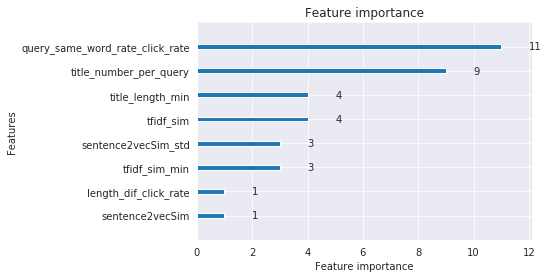

In [0]:
lgb.plot_importance(gbm, max_num_features=10)

In [0]:
lgb.plot_tree(gbm, tree_index=3, figsize=(100, 40), show_info=['split_gain'])

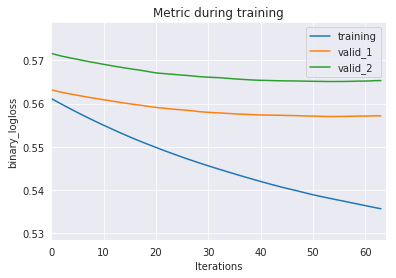

In [0]:
lgb.plot_metric(evals_result, metric='binary_logloss')

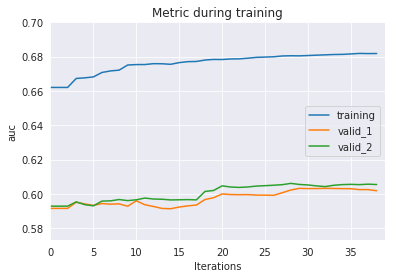

In [0]:
lgb.plot_metric(evals_result, metric='auc')

In [0]:
#calculate Normalized Cross Entropy
NE = (-1) / len(y_pred) * sum(((1+y_test_reset)/2 * np.log(y_pred) +  (1-y_test_reset)/2 * np.log(1 - y_pred)))
print("Normalized Cross Entropy " + str(NE))

Normalized Cross Entropy 0.9443404795631408


In [0]:
# from sklearn.linear_model import LogisticRegression
# lm = LogisticRegression(penalty='l2',C=0.05) # logestic model construction
# lm.fit(x_train,y_train)  # fitting the data
# y_pred_test = lm.predict_proba(x_validation)   # Give the probabilty on each label
# y_pred_label = lm.predict(x_validation) 